### **2**

In [89]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer

In [74]:
df = pd.read_csv('/content/RC/challenge_data.csv')

df['last_change_date'] = pd.to_datetime(df['last_change_date'])
df['year'] = df['last_change_date'].dt.year
df['month'] = df['last_change_date'].dt.month
df['day'] = df['last_change_date'].dt.day
df['year'] = df['year'].fillna(0)
df['month'] = df['month'].fillna(0)
df['day'] = df['day'].fillna(0)

y = df.impago
X = df.drop(['impago', 'id', 'last_change_date'], axis = 1)
for column in X.select_dtypes(include=['object']).columns:
    X[column] = X[column].astype('int64')

df.shape

(200000, 36)

In [75]:
df.dtypes

id                                            object
num_cuentas_activas                            int64
num_cuentas_cerradas                           int64
max_credit                                   float64
mean_credit                                  float64
total_credit                                 float64
mean_balance                                 float64
total_balance                                float64
total_utilizacion                            float64
monto_en_mora                                float64
pagos_vencidos                                 int64
banco_count                                    int64
banco_limite                                   int64
banco_utilizacion                            float64
last_change_date                      datetime64[ns]
first_amount                                 float64
last_amount                                  float64
times_increased                                int64
max_increase                                  

In [76]:
#Genera pipeline para las variables numericas que son todas
#aqui no se estandariza ya que los arboles y por lo tanto los bosques
#no muestran grandes cambios se haga o no
num_transformer = Pipeline([('imputer', SimpleImputer(strategy='median'))])
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

prep = make_column_transformer((num_transformer, num_cols),
                               remainder= 'passthrough')

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state = 16)

mod = RandomForestClassifier(class_weight="balanced")

pipe = Pipeline([('preprocessor', prep),
                ('model', mod)])

params = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5, 10]
}

gs = GridSearchCV(pipe, param_grid=params, scoring = "f1", cv = 5, n_jobs = -1)

gs.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('pipeline',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median'))]),
                                                                         Index(['num_cuentas_activas', 'num_cuentas_cerradas', 'max_credit',
       'mean_credit', 'total_credit', 'mean_balance', 'total_balance',
       'total_utilizacion', 'monto_en_mora...
       'total_pagos', 'total_gastos', 'porcentaje_uso_limite_de_cuenta',
       'porcentaje_compras_msi', 'porcentaje_compras_mci',
       'porcentaje_rubros_basicos', 'year', 'month', 'day'],
      dtype='object'))])),
                                       ('model',
                                        RandomForestClassifier(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [None, 10, 20],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring='f1')

In [79]:
best = gs.best_estimator_
y_pred=best.predict(X_test)
print(accuracy_score(y_pred, y_test))
print(confusion_matrix(y_pred, y_test)/40000)


0.921975
[[0.737425 0.05805 ]
 [0.019975 0.18455 ]]


In [ ]:
#revisar la accuracy del modelo
#y_pred = pipe.predict(X_test)
#accuracy_score(y_pred, y_test)

In [80]:
confusion_matrix(y_pred, y_test)/40000

array([[0.737425, 0.05805 ],
       [0.019975, 0.18455 ]])

In [82]:
rf_model = best.named_steps['model']
importances = rf_model.feature_importances_
feature_names = X.columns
#indices = np.argsort(importances)[::-1]

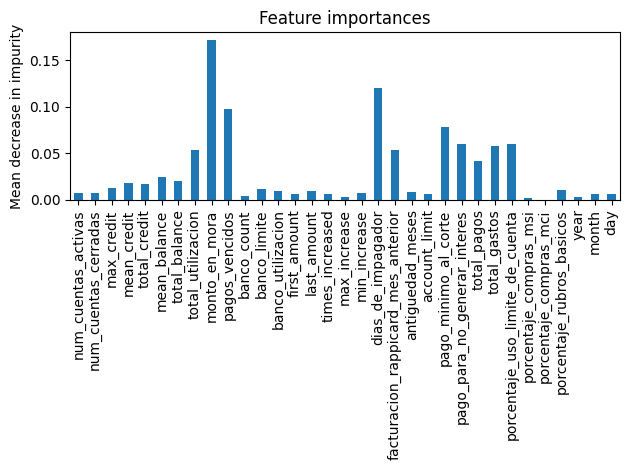

In [83]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

Las tres variables con mayor importancia en la probabilidad de default son Monto en mora, días de impagador y pagos vencidos. Las tres están muy relacionadas pero cada una en distintas dimensiones.


*   Monto en mora se refiere al monto total que el cliente debe en sus cuentas de acuerdo al Buró de Crédito, por lo que a mayor dinero que un cliente deba a bancos, mayor debe ser su probabilidad de no poder pagarlo.
*   Días de impagador está altamente relacionado a la probabilidad de default dado que independientemente del valor de impago, más tiempo sin pagar se traduce después de determinado tiempo en un default.
*   El número de pagos vencidos se relaciona con la probabilidad de default al tener el cliente un historial previo de impago existe mayor posibilidad de que esto vuelva a ocurrir.





## 3

Al obtener y verificar el accuracy del modelo, se puede revisar que este este bien calibrado de acuerdo a lo observado. Para esto se generó un set de validacion aislado de los efectos de entrenamiento y también del testing. Este set de validación contiene 20% de las observaciones (40,000 cuentas), por lo  que se puede dividir en cinco bins de 8,000 cuentas en las que se puede comparar la probabilidad observada en cada una contra la predicha por el modelo.

In [84]:
#Se empieza por aleatorizar el set de validacion (uniendo X, y para hacerlo en menos pasos)

X_val['impago'] = y_val

X_val.sample(frac = 1).reset_index(drop=True)

bins = np.array_split(X_val, 5)

In [90]:
#Iterar sobre los bins

proba_obs =[]
proba_pred = []
acc = []
f1 = []
recall = []
prec = []

for bin in bins:

  y_bin = bin.impago
  X_bin = bin.drop('impago', axis = 1)

  obs = y_bin.sum()/8000

  proba_obs.append(obs)

  y_pred = best.predict(X_bin)
  pred = y_pred.sum()/8000

  proba_pred.append(pred)

  acc.append(accuracy_score(y_bin, y_pred))
  f1.append(f1_score(y_bin, y_pred))
  recall.append(recall_score(y_bin, y_pred))
  prec.append(precision_score(y_bin, y_pred))

print(proba_pred)
print(proba_obs)
print(acc)
print(f1)
print(recall)
print(prec)


[0.203875, 0.207375, 0.208375, 0.21225, 0.206375]
[0.24375, 0.244375, 0.2435, 0.2525, 0.240125]
[0.921625, 0.9225, 0.924375, 0.92025, 0.92475]
[0.8249092432281485, 0.8284449363586054, 0.8326417704011064, 0.8284023668639053, 0.8314669652855542]
[0.7574358974358975, 0.7657289002557545, 0.7725872689938398, 0.7623762376237624, 0.7730348776678813]
[0.9055793991416309, 0.9023508137432188, 0.9028194361127775, 0.9069493521790342, 0.8994548758328286]


## 4

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 16)

mod = LogisticRegression()

#Genera pipeline para las variables numericas que son todas
#num_transformer = Pipeline([('imputer', SimpleImputer(strategy='mean')),
#                            ('scaler', StandardScaler())])
#num_cols = X.select_dtypes(include=['int64', 'float64']).columns

#prep = make_column_transformer((num_transformer, num_cols),
#                               remainder= 'passthrough')

pipe = Pipeline([('imputer', SimpleImputer(strategy='mean')),
                 ('scaler', StandardScaler()),
                 ('model', mod)])

params = {'model__C': [0.1, 1, 10, 100], 'model__solver': ['liblinear']}

gs = GridSearchCV(pipe, param_grid = params, cv = 5, scoring='accuracy')
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('model', LogisticRegression())]),
             param_grid={'model__C': [0.1, 1, 10, 100],
                         'model__solver': ['liblinear']},
             scoring='accuracy')

In [94]:
y_pred = gs.predict(X_test)
accuracy_score(y_pred, y_test)

0.9118833333333334

In [95]:
best_mod = gs.best_estimator_
best_mod.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('model', LogisticRegression(C=10, solver='liblinear'))])

In [96]:
log_reg_model = best_mod.named_steps['model']
coefficients = log_reg_model.coef_
coefficients

array([[ 3.71275616e-01,  1.23371744e-02,  1.57405930e+00,
        -2.03290601e-01, -1.94305343e+00,  3.45058783e-02,
        -3.83368977e-02, -1.76840801e-01,  6.77446851e-02,
         5.96015424e-02, -2.89832955e-01,  2.44427452e-01,
        -4.68660364e-02, -4.54695068e-01, -4.33706105e-01,
        -2.22984366e-01,  3.39548036e-02,  3.41389984e-02,
         3.23552414e+00,  1.79403667e-01, -1.34563165e-01,
        -4.58022707e-01,  2.19587604e+00,  3.07292043e-01,
         6.53816363e-01,  1.76665297e-01, -3.28148764e-01,
         2.89955083e-03, -6.03427609e-03,  2.44110083e-02,
        -2.22793008e-01,  1.20244988e-01,  2.05106258e-02]])

In [97]:
coefficients_with_names = list(zip(X.columns, coefficients[0]))

In [109]:
coefs= pd.DataFrame(coefficients_with_names, columns = ['feature', 'coefficient'])
coefs.sort_values(by ='coefficient')

,feature,coefficient
4,total_credit,-1.943053
21,account_limit,-0.458023
13,first_amount,-0.454695
14,last_amount,-0.433706
26,porcentaje_uso_limite_de_cuenta,-0.328149
10,banco_count,-0.289833
15,times_increased,-0.222984
30,year,-0.222793
3,mean_credit,-0.203291
7,total_utilizacion,-0.176841


De acuerdo a los coeficientes del modelo de Regresión Logística y debido a la estandarización de todos los campos de la base, un aumento en una desviación estándar -la cual es de $2361- de la línea de crédito aumentará en aproximadamente 3% la probabilidad de impago. Esto es muy similar para el incremento máximo y mínimo según los coeficientes mostrados por el modelo.

Para elaborar una estrategia de incremento de crédito que minimice el riesgo de impago, sería necesario fijarse en otras variables del modelo que actúen en dirección contraria al incremento de probabilidad de impago. Al explorar la magnitud y signo de los coeficientes, se observa que la variable de crédito total en Buró de Crédito va en dirección opuesta a la probabilidad de impago, esto tiene sentido ya que un cliente con altos niveles de crédito necesita comprobar un ingreso que pueda pagarlos. De igual manera, el límite de crédito en RappiCard y el monto de las líneas de crédito en RappiCard funcionan como reflejo de la situación financiera de los clientes. La quinta variable más importante, el porcentaje del uso límite de la cuenta, se puede relacionar con la conducta del cliente hacia su crédito y cómo se comporta con respecto al límite de crédito asignado.
Las cinco variables consideradas anteriormente pueden ayudar a elaborar la estrategia de asignación de incrementos de crédito, al reflejar características deseables de clientes que tienen baja probabilidad de caer en impago pueden ser consideradas para filtrar y determinar clientes que sean candidatos a un aumento en su línea de crédito. Para lograr esto, un buen inicio sería tomar los resultados de este modelo como base e ingresar los datos del cliente respecto a las variables mencionadas anteriormente en la fórmula extendida de regresión logística para ver su probabilidad de impago, obteniendo así una probabilidad de impago dadas las características guardadas del cliente. Con esto, se podría determinar un límite inferior de probabilidad de impago y determinar los clientes a los que se podría ofrecer el incremento.

In [107]:
df.max_increase.std()

2361.7612814167287

##5

Con los insights obtenidos en las preguntas previas, para determinar a qué clientes brindarles un aumento en su línea de crédito empezaría por utilizar los modelos creados para calcular su probabilidad de impago dadas todas sus características. Un VotingClassifier podría ser una opción para utilizar ambos modelos y agregaría algún modelo de boosting para tener un número impar de modelos.

Teniendo la predicción de impago de acuerdo al modelo de votación, buscaría a aquellos clientes por encima de cierto límite para determinar el grupo candidato a aumentos.
Este límite de probabilidad de impago habría que ser consultado con información histórica para determinar cuál es el nivel de riesgo que se quiere asumir.

## 6

Existen múltiples formas de determinar el monto de aumento de créditos dado que ya se conoce la probabilidad de impago de este grupo, tanto predicha como observada. Además, se asume que los clientes se van a seguir comportando como se comportaron previamente.

En este caso se podría empezar por preguntar cuál es la ganancia que se busca obtener al aumentar estas líneas de crédito en función del crédito total y el porcentage de utilización.

Se empieza por determinar cuál es la ganancia dado el nivel de crédito. Este se calcula determinando el nivel de ganancia que se obtiene del monto utilizado de créditos, que es el límite de crédito actual de cada cliente multiplicado por su porcentaje de utilización de crédito. De esta manera se obtiene el monto real que están pagando los clientes con su tarjeta.

Obtenido el monto utilizado de crédito por cliente, se puede obtener el monto utilizado total y por lo tanto el nivel de ganancia obtenido de éste (de datos financieros de la empresa). Obtenidas estas cifras se puede calcular cuánto tendría que incrementar el crédito para obtener la ganancia objetivo, pero se tiene que tomar en cuenta la probabilidad de impago en este grupo que se minimizó pero sigue siendo mayor a cero. Para compensar este riesgo de impago, se divide por la probabilidad de no impago, aumentando ligeramente el monto de crédito pero si todo lo demás se mantiene igual compensaría las pérdidas por impago.

La diferencia entre el monto utilizado total original y el nuevo calculado se puede determinar como el nivel de crédito por asignar para todo el grupo de clientes. Al tener clientes con distintos niveles de crédito y características de riesgo no se puede asigar a todos el mismo aumento, por lo que se puede buscar aumentar el crédito de manera proporcional a su monto de crédito actual ya sea con algún tipo de pesos para no asignar demasiado a aquellos con créditos muy grandes ni muy poco a aquellos con créditos pequeños.
